In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
from pprint import pprint

#BITCOIN API: url setup
url = 'https://api.coindesk.com/v1/bpi/historical/close.json?'
default = 'start=2020-01-01&end=2020-12-31'

# set start and end date variables
# NOTE: Social unrest dates (George Floyd)
start_date = '2020-05-25'
end_date = '2020-06-05'

# DOW: file to Load, read csv, dataframe
file_to_load = "data/dow.csv"
dow_data = pd.read_csv(file_to_load)
dow_data_df = pd.DataFrame(dow_data)

# GOLD: file to load, read csv, dataframe
file_to_load = "data/gold.csv"
gold_data = pd.read_csv(file_to_load)
gold_data_df = pd.DataFrame(gold_data)
gold_data_df.columns = gold_data_df.columns.tolist()[:1] + ['Close'] + gold_data_df.columns.tolist()[2:]


In [2]:
query_url = f'{url}start={start_date}&end={end_date}'
pprint(requests.get(query_url).json())

{'bpi': {'2020-05-25': 8776.34,
         '2020-05-26': 8871.05,
         '2020-05-27': 8923.05,
         '2020-05-28': 9207.95,
         '2020-05-29': 9448.365,
         '2020-05-30': 9550.815,
         '2020-05-31': 9545.15,
         '2020-06-01': 9564.95,
         '2020-06-02': 10136.5,
         '2020-06-03': 9594.45,
         '2020-06-04': 9529.55,
         '2020-06-05': 9836.805},
 'disclaimer': 'This data was produced from the CoinDesk Bitcoin Price Index. '
               'BPI value data returned as USD.',
 'time': {'updated': 'Jun 6, 2020 00:03:00 UTC',
          'updatedISO': '2020-06-06T00:03:00+00:00'}}


In [3]:
response = requests.get(query_url).json()
my_dict = response['bpi']
btc_df = pd.DataFrame(list(my_dict.items()),columns = ['Close Date','Close Price']) 
btc_df['Close Date'] = pd.to_datetime(btc_df['Close Date'])
btc_df 

,Close Date,Close Price
0,2020-05-25,8776.340
1,2020-05-26,8871.050
2,2020-05-27,8923.050
3,2020-05-28,9207.950
4,2020-05-29,9448.365
5,2020-05-30,9550.815
6,2020-05-31,9545.150
7,2020-06-01,9564.950
8,2020-06-02,10136.500
9,2020-06-03,9594.450


In [4]:
dow_data_df['Date'] = pd.to_datetime(dow_data_df['Date'])

dow_clean = dow_data_df.loc[(dow_data_df['Date'] >= start_date) & (dow_data_df['Date'] <= end_date)]
dow_clean = dow_clean[['Date', 'Close']]

dow_df = dow_clean.rename(columns={'Date':'Close Date','Close':'Close Price'})

dow_df

,Close Date,Close Price
100,2020-05-26,24995.10938
101,2020-05-27,25548.26953
102,2020-05-28,25400.64063
103,2020-05-29,25383.10938
104,2020-06-01,25475.01953
105,2020-06-02,25742.65039
106,2020-06-03,26269.89063
107,2020-06-04,26281.82031
108,2020-06-05,27110.98047


In [5]:
gold_data_df['Date'] = pd.to_datetime(gold_data_df['Date'])

# clean data - take out out-of-range data based on start_/end_date variables above
# return only date and close price columns
gold_clean = gold_data_df.loc[(gold_data_df['Date'] >= start_date) & (gold_data_df['Date'] <= end_date)]
gold_clean = gold_clean.sort_values(by=['Date']).reset_index(drop=True)
gold_clean = gold_clean.iloc[:,0:2]

# rename date column to prep for merge
gold_df = gold_clean.rename(columns={'Date':'Close Date','Close':'Close Price'})

#gold_df

In [6]:
merged = pd.merge(btc_df, dow_df, on='Close Date', how='left')
merged = pd.merge(merged, gold_df, on='Close Date', how='left', suffixes=('_dow','_gold'))
merged = merged.rename(columns={'Close Date':'Date','Close Price_x':'Bitcoin','Close Price_y':'Dow Jones','Close Price':'Gold'})
merged = merged.dropna()
bitcoin_x = merged['Bitcoin']
dow_x = merged['Dow Jones']
gold_x = merged['Gold']
all_y = merged['Date']

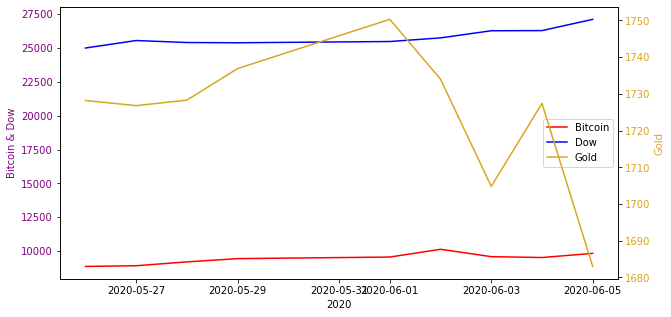

In [7]:
color_bit = 'red'
color_dow = 'blue'
color_gold = 'goldenrod'
color_label = 'purple'

fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_x, color=color_dow, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_xlabel('2020')
ax1.set_ylabel('Bitcoin & Dow', color=color_label)
ax1.plot()

# set up second y-axis *see link*
ax2 = ax1.twinx()

# plot second y-axis
ax2.set_ylabel('Gold', color=color_gold)
plot3 = ax2.plot(all_y, gold_x, color=color_gold, label= 'Gold')
ax2.tick_params(axis='y', labelcolor=color_gold)

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(10, 5, forward=True)

plt.show()

In [8]:
percent_dow = dow_x.pct_change()
percent_dow
percent_bitcoin = bitcoin_x.pct_change()
percent_bitcoin
percent_gold = gold_x.pct_change()
percent_gold

merged['% Chg Dow'] = percent_dow
merged.head()

merged['% Chg Bitcoin'] = percent_bitcoin
merged.head()

merged['% Chg Gold'] = percent_gold 
merged.head(10)
merged = merged.dropna()

In [12]:
merged.head(8)

,Date,Bitcoin,Dow Jones,Gold,% Chg Dow,% Chg Bitcoin,% Chg Gold
2,2020-05-27,8923.050,25548.26953,1726.8,0.022131,0.005862,-0.000810
3,2020-05-28,9207.950,25400.64063,1728.3,-0.005778,0.031929,0.000869
4,2020-05-29,9448.365,25383.10938,1736.9,-0.000690,0.026110,0.004976
7,2020-06-01,9564.950,25475.01953,1750.3,0.003621,0.012339,0.007715
8,2020-06-02,10136.500,25742.65039,1734.0,0.010506,0.059755,-0.009313
9,2020-06-03,9594.450,26269.89063,1704.8,0.020481,-0.053475,-0.016840
10,2020-06-04,9529.550,26281.82031,1727.4,0.000454,-0.006764,0.013257
11,2020-06-05,9836.805,27110.98047,1683.0,0.031549,0.032242,-0.025703


In [ ]:
Gold = plt.plot(all_y, gold_x, color="gold", label="Gold")
fig.set_size_inches(10, 5, forward=True)
plt.title("Social Unrest: Gold")
plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams.update({'font.size': 2})